In [1]:
import os as os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib as plt

# TL;DR 

I built a student loan repayment calculator based on family income and SAT scores to estimate the probability a student will be able to pay off a loan

*** Important findings ***

(1) College is certainly overpriced- based on the repayment rate

(2) If you come from a wealthy family, you'll probably be able to pay your student loans off, regardless of your   aptitude.  Y

**If you come from a poor family... read on**

(3) If you come from a poor family you need to think seriously about the decision to go to college. 

(4) If you didn't do well on the ACT or SAT, you are very likely to drop out of college, and more importantly you are extremely likely to be in over your head with student loans.

(5) Pell grants are not helping students from poor families avoitd stude loan debt

# The Student Loan Problem

***Background and Motivation for Project***

As of 2018, the student loan deficit has climbed to 1.5 trillion dollars. A whopping 70% of college students graduate with student loan debt. The average borrower takes out a loan totaling ~$37,000.  Even more troubling is the fact that about half of students have not made any progress on repaying their student loans 5 years after graduating (in other words, they have paid off none of the principle

***Why have student loans spiralled so far out of control?***  

(1) As a nation, we have collectively adopted the idea that everyone should attend college.

(2) In 1998, congress made federal student loans non-dischargeable, unless the debtor could demonstrate that the loan was creating an undue hardship. More importantly, in 2005, Congress extended this protection to private student loans. (Undue hardship is extremely hard to claim).

(3) The non- dischargeable nature of student loans mitigates much the risk associated with these loans, thereby allowing banks to make 'subprime' loans to students.

(4) The above points allow students to take out student loans regardless of their readiness for college. Since most students have bought into the narrative described in point (1), they take on these loans without much thought as to how they are going to be able to pay them back.

***The Inelasticity Paradox***

The wide availability of student loans coupled with the high demand for student loans has caused student loans to become more inelastic. In other words, students seem to be willing to go to college without much thought to the price.

Interestingly, this presents a bit of a paradox. We live in an information-rich age. Universities used to be the places you had to go to have access to special/hidden knowledge. Today, there is a ton of free information available to the public, on sources such as youtube tutorials and lectures and massively open online courses (MOOCs). In theory, this should lower the cost of education, but in practice the rise in tuition rates is still doubling the inflation rate.  

***Solving The Problem***

Too many students are taking on student loan debt in the anticipation that they will get a job that will allow them to pay back their student loans.  This is a fantasy for many students.  

I want to help students make better decisions on whether to take out student loans.  Along these lines, I have analyzed data house in the Department of Education's College Scorecard.  This repository contains student loan data, median family income, average entrance exam scores, as well as many other metrics (somewhere around 1800 in all).

By analyzing this data I have found that two factors are incredibly predictive in determining whether students will be successful in paying off their student loans: entrance exam scores and family income.  Based solely on these two metrics, I can make a model that will accurately predict student loan repayment rates.  

I want to use this model to help students understand their probability of being able to pay off their student loans if they decide to attend college.



# Let's look at some data
-  The data used in this analysis was downloaded from CollegeScorecard: https://collegescorecard.ed.gov/data/

-  College Scorecard Data: https://ed-public-download.app.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip

-  Post School Earnings: https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-Treasury-Elements.csv

**The following code will download and unzip the datasets.**


In [2]:
# Download the data
import wget
import os as os
import zipfile
url_1 = 'https://ed-public-download.app.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip' 
url_2 = 'https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-Treasury-Elements.csv'
def getdata(url):
    directory = os.getcwd()
    wget.download(url, directory)
    if url.endswith('.zip'):
        with zipfile.ZipFile("CollegeScorecard_Raw_Data.zip","r") as zip_ref:
            zip_ref.extractall(directory)
getdata(url_1)
getdata(url_2)

**To get a little familiarity with the data I will load in the data with Pandas, and will merge the scorecard data with the treasury elements data (both have a column for institution name (called 'INSTNM').   After this, I will perform a head command to look at the data.**

In [4]:
pd.set_option('display.max_columns', 2000)
scorecard_data = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2016_17_PP.csv',low_memory = False)
scorecard_data.head()
treasury_elements = pd.read_csv('Most-Recent-Cohorts-Treasury-Elements.csv')
scorecard_merged_data = scorecard_data.merge(treasury_elements, on = 'INSTNM', how= 'left')


As we can see, there are over 1800 columns and the column headers are quite cryptic.  Luckily, college scorecard provides a yaml file that contains descriptions of all of the columns.  They also provide a PDF on their website with descriptions of the data: 
-  https://collegescorecard.ed.gov/assets/FullDataDocumentation.pdf



### Student Loan Default Rates and Repayment Rates 

In the data descriptions I found the three year cohort default rate ('CDR3') as well as the three year repayment rate ('RPY_3_YR_RT'). The three year repayment rate is defined as the fraction of students whose loans have decreased three years after graduation. 




In [5]:
three_year_default_rate = scorecard_data['CDR3'].mean()
three_year_repay_rate = scorecard_data['RPY_3YR_RT'].apply(pd.to_numeric, errors='coerce').mean()
five_year_repay_rate = scorecard_data['RPY_5YR_RT'].apply(pd.to_numeric, errors='coerce').mean()
print('The three year default rate is: ' + str(three_year_default_rate * 100) + ' %')
print('The three year repayment rate is: ' + str(three_year_repay_rate * 100) + ' %')


The three year default rate is: 11.870982940698612 %
The three year repayment rate is: 44.92909273890448 %


This is not good news.  We can see that, on average across universities, three years after graduation, the default rate is already almost 12%.  More importantly, if we look at the repayment rate we can see that at most colleges, less than half of the students have made any progress at attacking the principle on their student loans.  

**Lets see if the repayment rate gets any better over time**

   years_after_graduation  repaymnet_rate
0                       3        0.449291
1                       5        0.487274
2                       7        0.534238
slope:  0.021236781350943743


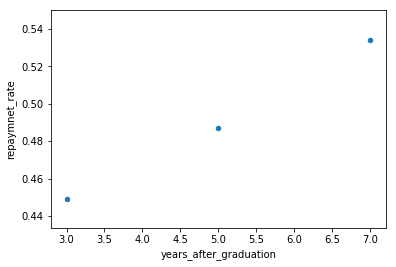

In [6]:
import matplotlib as plt
from scipy import stats
%matplotlib inline
years = [ 3, 5, 7]
repay = []
for num in years:
    repay_rate = scorecard_data['RPY_' + str(num) + 'YR_RT'].apply(pd.to_numeric, errors = 'coerce').mean()
    repay.append(repay_rate)
df = pd.DataFrame({'years_after_graduation':years, 'repaymnet_rate':repay})
df.plot('years_after_graduation', 'repaymnet_rate', kind='scatter')
print(df)
slope, intercept, r_value, p_value, std_err = stats.linregress(years,repay)
print("slope: ", slope)


We can see that, luckily, the repayment rate gets better with time.  

Unfortunately, we only observe a 2% increase in loan repayments across universities per year.  This suggests that loan payment rates are fairly static.

** Student Loans by program type **

There are 4 different types of universities in the College Scorecard: there are institutions that are certificate degree-granting, associate's degree-granting, bachelor's degree-granting, entirely graduate degree-granting, and unclassified. 

Let's examine how each of these types of institutions fair in repayment rates.



Text(0.5,0,'repayment_rate')

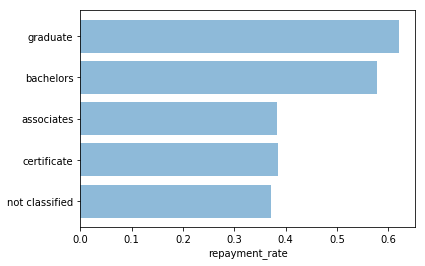

In [7]:
import matplotlib as plt

di = {0:'not classified', 1:'certificate', 2:'associates', 3:'bachelors', 4:'graduate'}
x = scorecard_data[['PREDDEG', 'RPY_3YR_RT']]
x = x.apply(pd.to_numeric, errors='coerce')
x = x.groupby('PREDDEG').mean().reset_index()
x = x.replace({"PREDDEG": di})
objects = list(di.values())
y_pos = np.arange(len(objects))
repayment = x.RPY_3YR_RT
plt.pyplot.barh(y_pos, repayment, align='center', alpha=0.5)
plt.pyplot.yticks(y_pos, objects)
plt.pyplot.xlabel('repayment_rate')


Immediately, we can see that graduate and bachelor's degree-granting programs have much better repayment rates than associates-granting, certificate-granting, and unclassified programs. 

# Aptitude and repayment rates.  Brains Matter

In order to first begin to tease apart which factors are most relevant to student loan repayment, I first examined the relationship between student aptitude and repayment rates.  I first plotted SAT vs ACT scores to make sure there were no obvious biases in using one over the other.



The coefficient of determination is: 0.9660260251136745


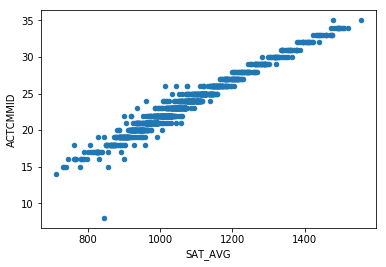

In [8]:
x = scorecard_data[['SAT_AVG','ACTCMMID']]
x = x.apply(pd.to_numeric, errors='coerce')
x = x.dropna()
x.plot('SAT_AVG', 'ACTCMMID', kind='scatter')
slope, intercept, r_value, p_value, std_err = stats.linregress(x['SAT_AVG'],x['ACTCMMID'])
r_squared = r_value**2
print('The coefficient of determination is:', r_squared)

As expected, SAT and ACT scores are tightly correlated.  From here on out, I will use SAT scores instead of ACT scores as a proxy for staudent aptitude, as SAT scores offer finer resolution due to the scoring methodology. 

** Let's examine how SAT correlate with repayment rates **

Optimization terminated successfully.
         Current function value: 0.622064
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             RPY_3YR_RT   No. Observations:                 1284
Model:                          Logit   Df Residuals:                     1283
Method:                           MLE   Df Model:                            0
Date:                Tue, 12 Feb 2019   Pseudo R-squ.:                 -0.4267
Time:                        14:21:45   Log-Likelihood:                -798.73
converged:                       True   LL-Null:                       -559.84
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SAT_AVG        0.0005   5.45e-05      9.741      0.000       0.000       0.001
==============================================================================
"""

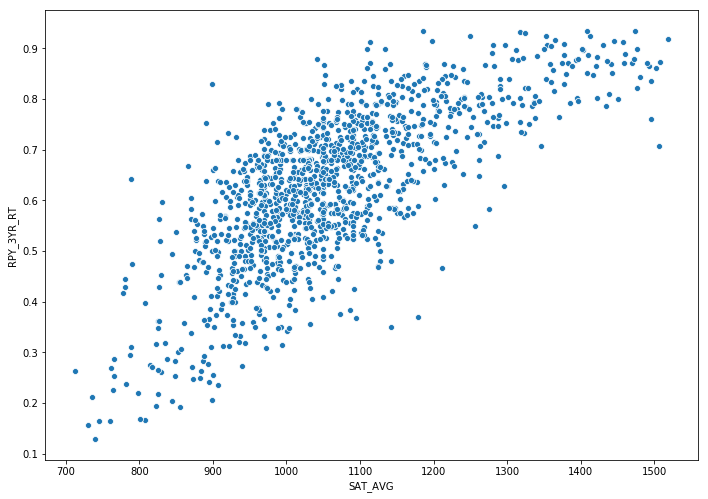

In [10]:
import seaborn as sns
import matplotlib as plt
x = scorecard_data[['SAT_AVG','RPY_3YR_RT', 'CDR3']]
x = x.apply(pd.to_numeric, errors='coerce')
x=x.dropna()
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
sns.scatterplot('SAT_AVG', 'RPY_3YR_RT', data = x)

X = x['SAT_AVG']
y = x['RPY_3YR_RT']
model = sm.Logit(y,X)
result = model.fit()
result.summary()

First of all, we can see that there is a strong correlation between SAT scores and repayment rates.  This isn't that surprising.  However, I think that the shape of this distribution is incredibly important.

Notice that as average SAT scores for universities fall below 1200, the repayment rate begins to fall drastically.


# Students with low exam scores are unlikely to finish college

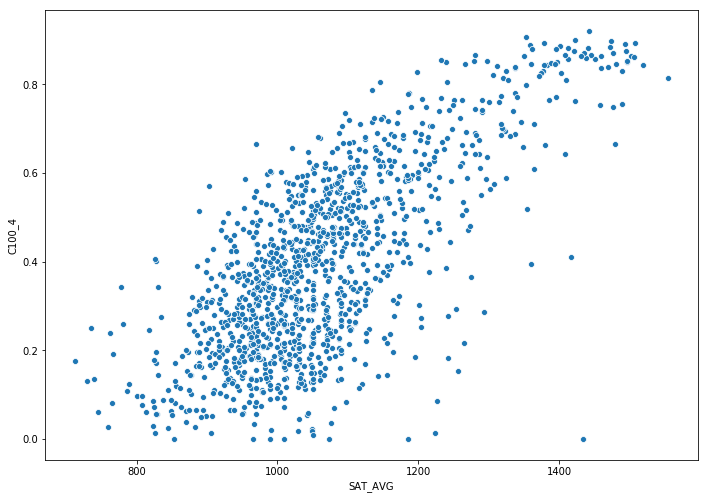

In [11]:
import seaborn as sns
import matplotlib as plt
x = scorecard_data[['SAT_AVG','C100_4', ]]
x = x.apply(pd.to_numeric, errors='coerce')
x=x.dropna()
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
sns.scatterplot('SAT_AVG', 'C100_4', data = x)

### Family Income and Student Loan Repayment 

We see in the previous graph that aptitude test score correlate strongly with repayment rates.  In the next sections I will examine the relationship between family income, test scores and student loan repayment.

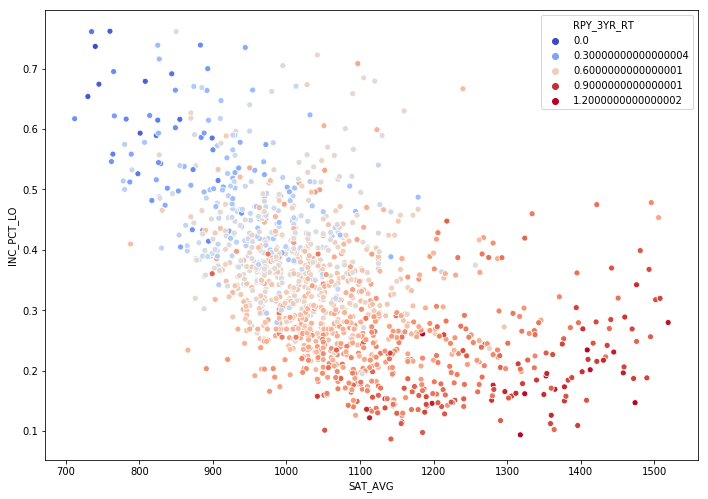

In [12]:
x = scorecard_data[['SAT_AVG','INC_PCT_LO','RPY_3YR_RT']]
x = x.apply(pd.to_numeric, errors='coerce')
x=x.dropna()
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
sns.scatterplot('SAT_AVG', 'INC_PCT_LO', data = x, hue = 'RPY_3YR_RT', palette= "coolwarm")
#slope, intercept, r_value, p_value, std_err = stats.linregress(x['SAT_AVG'],x['INC_PCT_LO'])
#p_value

In this chart we can see a strong negative correlation between percent of students from low income families and SAT scores.  Interestingly there is an upturn for Universities with the very highest SAT scores.  Suggesting that these universities are commited to accepting higher rates of low income students.

We can see in the chart below that repayment rates and percent low income families show a strong negative correlation.  Luckily, it seems that test scores can compensate.  Universities with high SAT scores tend to have high levels of repayment rates regardless of the fraction of students that come from low income families

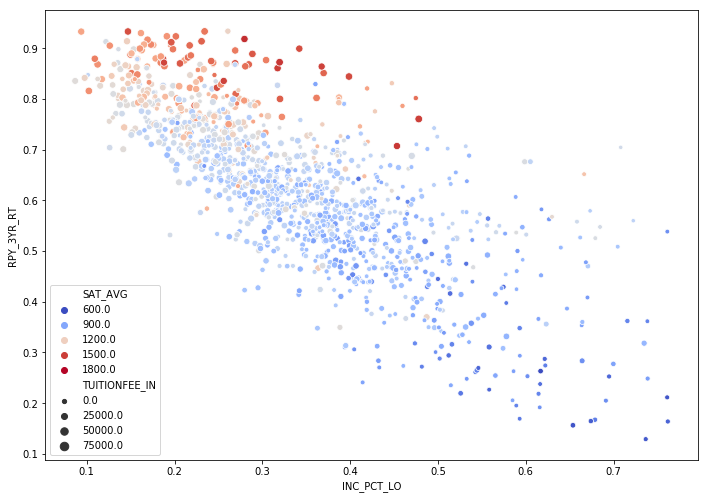

In [13]:
x = scorecard_merged_data[['INC_PCT_LO', 'SAT_AVG','RPY_3YR_RT','TUITIONFEE_IN']]
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="INC_PCT_LO", y="RPY_3YR_RT", hue= 'SAT_AVG', palette= "coolwarm", size='TUITIONFEE_IN', data=x)

Using Median family income we can observe a similar trend

[Text(0,0.5,'Median Family Income'), Text(0.5,0,'Average SAT score')]

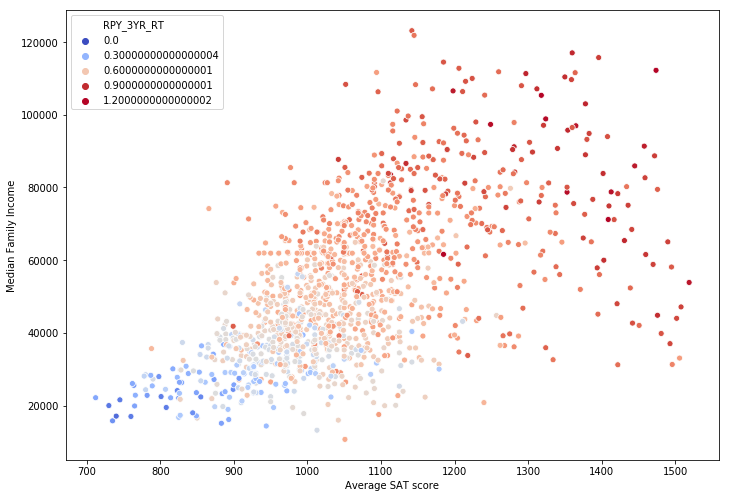

In [14]:
%matplotlib inline
x = scorecard_data[['MD_FAMINC', 'RPY_3YR_RT', 'SAT_AVG']]
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="SAT_AVG", y="MD_FAMINC", hue = "RPY_3YR_RT", palette= "coolwarm",  data=x)
y.set(xlabel='Average SAT score', ylabel='Median Family Income')


# Machine Learning analysis

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats

machine_learning_data = scorecard_merged_data[['SAT_AVG','MD_FAMINC','RPY_3YR_RT']]
machine_learning_data = machine_learning_data.apply(pd.to_numeric, errors='coerce')
machine_learning_data = machine_learning_data.dropna()
X_loan = machine_learning_data[[ 'SAT_AVG', 'MD_FAMINC']]
y_loan = machine_learning_data['RPY_3YR_RT']
min_max_scaler = preprocessing.MinMaxScaler()
X_loan_minmax = min_max_scaler.fit_transform(X_loan)

est = sm.OLS(y_loan, X_loan_minmax).fit()
print(est.summary())


X_train, X_test, y_train, y_test = train_test_split(X_loan_minmax, y_loan,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model intercept: {}'
     .format(linreg.intercept_))
print('linear model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))


from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train,y_train)


                            OLS Regression Results                            
Dep. Variable:             RPY_3YR_RT   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.463e+04
Date:                Tue, 12 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:22:16   Log-Likelihood:                 788.37
No. Observations:                1327   AIC:                            -1573.
Df Residuals:                    1325   BIC:                            -1562.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8757      0.022     40.582      0.0

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Repayment probability calculator

In [90]:
example = [[1400, 20000]]
example_scaled = min_max_scaler.transform(example)
model.predict(example_scaled)

array([0.68204285])

# Pell grants and Student loan repayment rates

One of the most troubling results I found during this analysis was the correlation between Pell grants and student loan repayment. Pell grants are federal grants that aid students from low income families in paying for college.

As you can see, universities with large proportions of students receiving Pell grants tend to have poor student loan repayment rates, in spite of the fact that are receiving aid. More concerning is the fact that the completion rate for these students is quite poor.

This chart calls into question the efficacy of Pell grants and whether they are doing more harm than good. For example, these grants may be encouraging students who have limited chance of succeeding in college to attend (based on the low completion rates). Since the maximum reward amount of these grants is barely enough to pay tuition at the cheapest colleges, students who receiving these grants almost certainly still have to take out student loans.


[Text(0,0.5,'Repayment Rate'),
 Text(0.5,0,'Fraction of Students Receiving Pell Grants')]

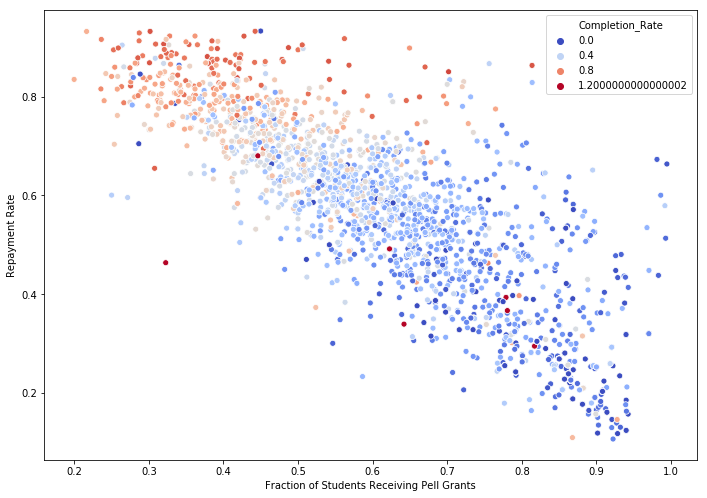

In [19]:
%matplotlib inline
x = scorecard_data[['PELL_EVER', 'RPY_3YR_RT', 'C100_4']]
x = x.rename(index=str, columns={"C100_4": "Completion_Rate"})
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="PELL_EVER", y="RPY_3YR_RT", hue = "Completion_Rate", palette= "coolwarm", data=x)
y.set(xlabel='Fraction of Students Receiving Pell Grants', ylabel='Repayment Rate')

[Text(0,0.5,'Income After College'), Text(0.5,0,'MD_FAMINC')]

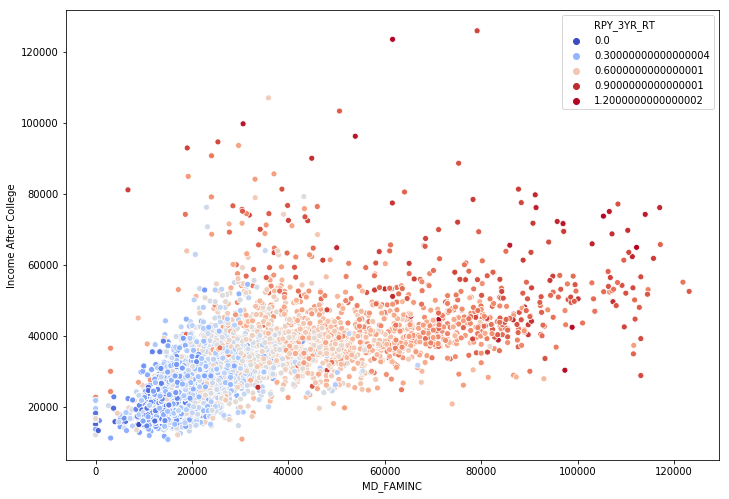

In [32]:
%matplotlib inline
x = scorecard_merged_data[['MD_EARN_WNE_P8_y', 'MD_FAMINC','RPY_3YR_RT']]
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="MD_FAMINC", y="MD_EARN_WNE_P8_y", hue = "RPY_3YR_RT", palette= "coolwarm", data=x)
y.set(xlabel='MD_FAMINC', ylabel='Income After College')

[Text(0,0.5,'RPY_3YR_RT'), Text(0.5,0,'GRAD_DEBT_MDN_SUPP')]

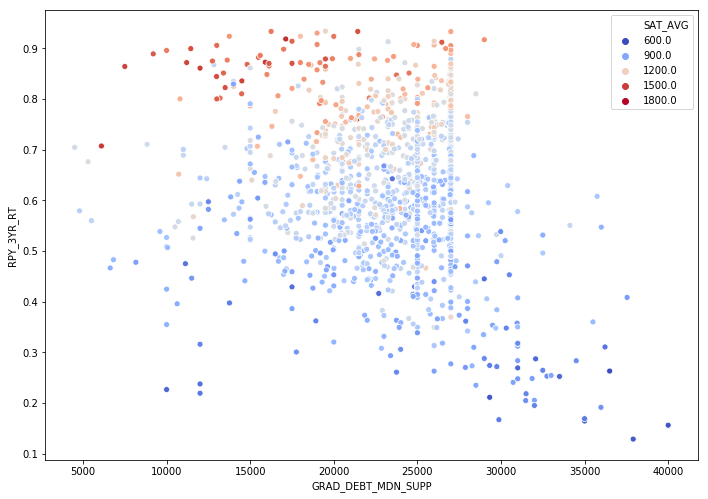

In [34]:
%matplotlib inline
x = scorecard_merged_data[[ 'GRAD_DEBT_MDN_SUPP','RPY_3YR_RT','SAT_AVG']]
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="GRAD_DEBT_MDN_SUPP", y="RPY_3YR_RT", hue = "SAT_AVG", palette= "coolwarm", data=x)
y.set(xlabel='GRAD_DEBT_MDN_SUPP', ylabel='RPY_3YR_RT')


In [86]:
x = scorecard_data[['RPY_5YR_RT', 'UGDS']]
x = x.apply(pd.to_numeric, errors='coerce')
x['total_repay'] = x['RPY_5YR_RT']* x['UGDS']
x['total_no_repay'] = (1 - x['RPY_5YR_RT'])* x['UGDS']
y = (x['total_repay'].sum()) / (x['UGDS'].sum())
y

0.5445754722162369

In [74]:
x = scorecard_data['LO_INC_YR2_N']
x = x.apply(pd.to_numeric, errors='coerce')
x.sum()
 


0.0

[Text(0,0.5,'TUITIONFEE_IN'), Text(0.5,0,'SAT_AVG')]

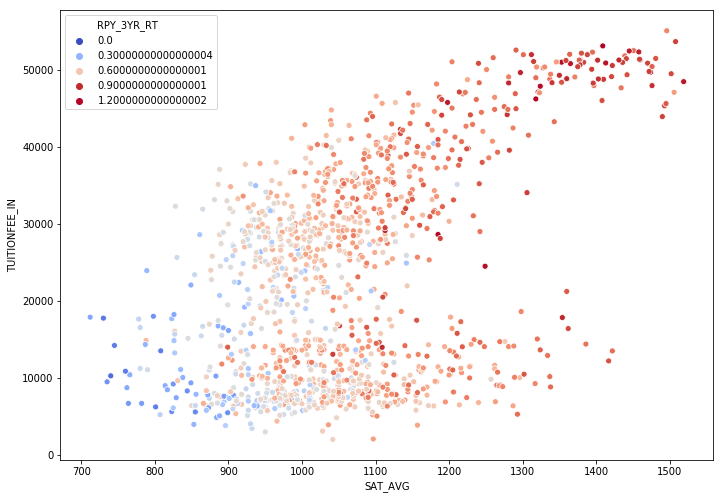

In [87]:
x = scorecard_merged_data[[ 'TUITIONFEE_IN','RPY_3YR_RT','SAT_AVG']]
x = x.apply(pd.to_numeric, errors='coerce')
a4_dims = (11.7, 8.27)
fig, ax = plt.pyplot.subplots(figsize=a4_dims)
y = sns.scatterplot(x="SAT_AVG", y="TUITIONFEE_IN", hue = "RPY_3YR_RT", palette= "coolwarm", data=x)
y.set(xlabel='SAT_AVG', ylabel='TUITIONFEE_IN')
